# Анализ данных Яндекс.Афиши

Описание проекта

Цель проекта - помочь маркетологам снизить расходы, соответственно, отказаться от невыгодных источников трафика и перераспределить бюджет.
У нас есть данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:
1. лог сервера с данными о посещениях сайта Яндекс.Афиши,
2. выгрузка всех заказов за этот период,
3. статистика рекламных расходов.

Необходимо изучить:
1. как клиенты пользуются сервисом,
2. когда делают первые покупки на сайте,
3. сколько денег приносит компании каждый клиент,
4. когда расходы на привлечение клиента окупаются.

Для достижения цели изучим и проанализируем метрики каждого вида: маркетинговые, продуктовые и метрики электронной коммерции.

## Изучение полученных данных 

В первую очередь изучим имеющиеся данные, проверив их на пропущенные значения и корректность типов данных.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')

In [3]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')
for data in [visits, orders, costs]: print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB
None


In [4]:
visits.head(5)

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [5]:
orders.head(5)

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [6]:
costs.head(5)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


### Вывод

Как можно увидеть, несмотря на то, что в данных отсутствуют пропущенные значения, они не свободны от других недостатков:
1.  названия столбцов неудобны для дальнейшей работы и находятся в неправильном регистре;
2.  столбцы, содержащие инфрмацию о датах и времени, имеют тип object вместо datetime.

## Предобработка данных

В первую очередь устраним недостатки, обозначенные выше: изменим названия столбцов и типы данных.

In [7]:
visits.columns = visits.columns.str.lower()
orders.columns = orders.columns.str.lower()
costs.columns = costs.columns.str.lower()

In [8]:
visits = visits.rename(columns={'end ts':'end_ts', 'source id':'source_id', 'start ts':'start_ts', 'uid': 'user_id'})
orders = orders.rename(columns={'buy ts':'buy_ts','uid': 'user_id'})
costs = costs.rename(columns={'dt':'date'})

In [9]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
user_id      359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


In [10]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
user_id    50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [11]:
costs['date'] = pd.to_datetime(costs['date'])
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
date         2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


In [12]:
print ('Пропущенных значений в таблице visits:', visits.isna().sum())
print ('Пропущенных значений в таблице orders:', orders.isna().sum())
print ('Пропущенных значений в таблице costs:', costs.isna().sum())

Пропущенных значений в таблице visits: device       0
end_ts       0
source_id    0
start_ts     0
user_id      0
dtype: int64
Пропущенных значений в таблице orders: buy_ts     0
revenue    0
user_id    0
dtype: int64
Пропущенных значений в таблице costs: source_id    0
date         0
costs        0
dtype: int64


In [13]:
print ('Дубликатов в таблице visits:', visits.duplicated().sum())
print ('Дубликатов в таблице orders:', orders.duplicated().sum())
print ('Дубликатов в таблице costs:', costs.duplicated().sum())

Дубликатов в таблице visits: 0
Дубликатов в таблице orders: 0
Дубликатов в таблице costs: 0


### Вывод

Данные готовы к анализу, пропущенные значения и дубликаты не обнаружены. Приступим к расчету необходимых метрик и построению графиков.

## Расчет продуктовых метрик

Приступим к  вычислению средних значений метрик DAU, WAU и MAU за весь период.

In [14]:
#Создадим необходимые для расчета метрик "временные" колонки
visits['session_year']  = visits['start_ts'].astype('datetime64[Y]')
visits['session_month'] = visits['start_ts'].astype('datetime64[M]')
visits['session_week']  = visits['start_ts'].astype('datetime64[W]')
visits['session_date'] = visits['start_ts'].dt.date
#print(visits.head())

In [15]:
dau_total = visits.groupby('session_date').agg({'user_id': 'nunique'}).mean()
print('Среднее количество уникальных пользователей в день составляет', int(dau_total), 'человек')

Среднее количество уникальных пользователей в день составляет 907 человек


In [16]:
wau_total = visits.groupby(['session_year', 'session_week']).agg({'user_id': 'nunique'}).mean()
print('Среднее количество уникальных пользователей в неделю составляет', int(wau_total), 'человек')

Среднее количество уникальных пользователей в неделю составляет 5621 человек


In [17]:
mau_total = visits.groupby('session_month').agg({'user_id': 'nunique'}).mean()
print('Среднее количество уникальных пользователей в месяц составляет', int(mau_total), 'человек')

Среднее количество уникальных пользователей в месяц составляет 23228 человек


Построим графики, показывающие изменения метрик по времени.

Text(0.5, 0, 'день')

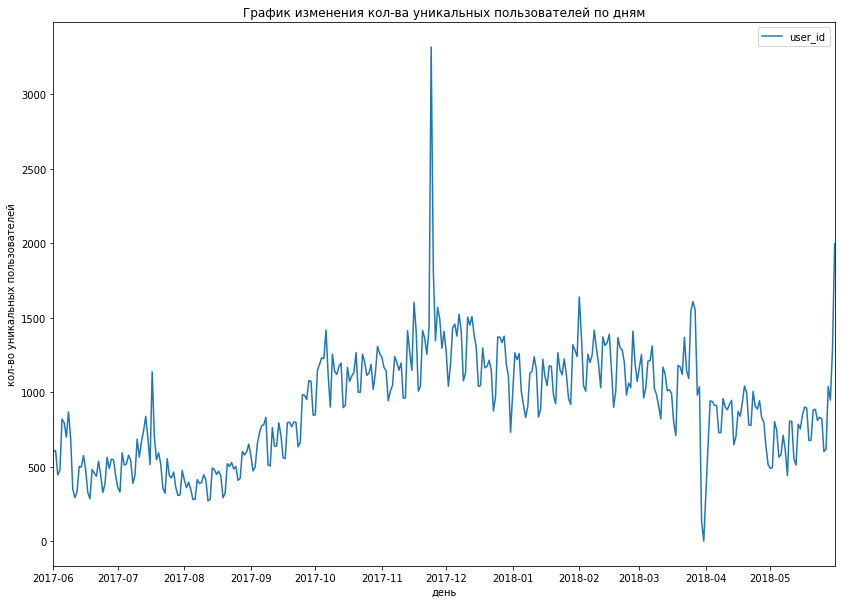

In [18]:
dau_time = visits.groupby('session_date').agg({'user_id': 'nunique'})
dau = dau_time.plot(figsize=(14, 10))
dau.set_title("График изменения кол-ва уникальных пользователей по дням")
dau.set_ylabel('кол-во уникальных пользователей')
dau.set_xlabel('день')

Text(0.5, 0, 'неделя')

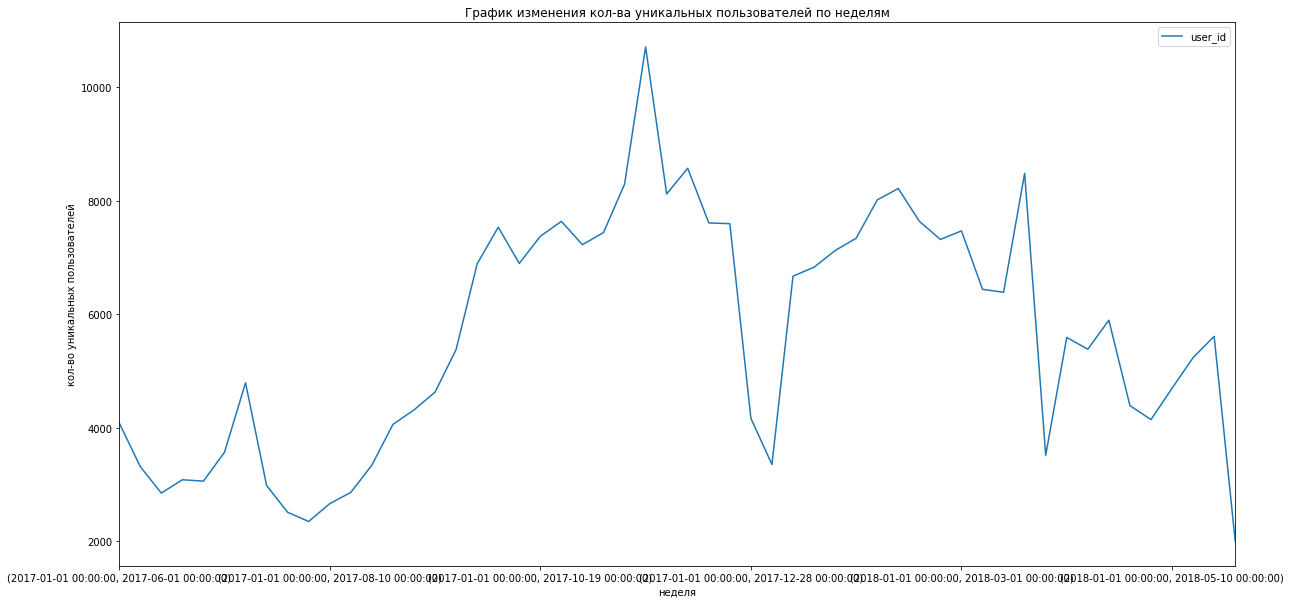

In [19]:
wau_time = visits.groupby(['session_year','session_week']).agg({'user_id':'nunique'})
wau = wau_time.plot(figsize=(20, 10))
wau.set_title("График изменения кол-ва уникальных пользователей по неделям")
wau.set_ylabel('кол-во уникальных пользователей')
wau.set_xlabel('неделя')

Text(0.5, 0, 'месяц')

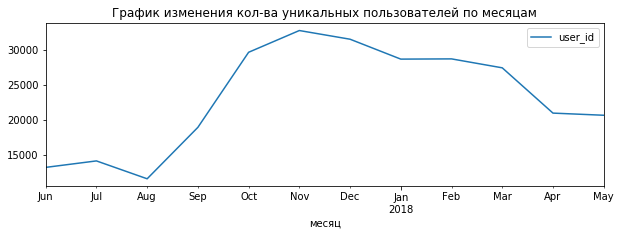

In [20]:
mau_time = visits.groupby('session_month').agg({'user_id': 'nunique'})
mau = mau_time.sort_values(by='session_month', ascending = True).plot(figsize=(10,3))
mau.set_title("График изменения кол-ва уникальных пользователей по месяцам")
mau.set_xlabel('месяц')

### Вывод

По результатам изучения данных об общей активности пользователей можно сделать вывод о том, что количество уникальных пользователей в день составляет 907 человек, в неделю - 5621, в месяц - 23228, что является достаточно хорошим показателем. Пик пользовательской активности по дням был замечен в начале декабря 2017 г., а точка спада - в конце марта-начале апреля 2018 г. При изучений недельной пользовательской активности можно отметить также активный приток новых пользователей в конце ноября-начале декабря и их постепенный отток после нового года. Месячное распределение активности пользователей имеет следующую картину распределения: с августа 2107 г.(точки минимума пользователей за исследуемый период) до ноября 2017 г. происходит непрерывный рост количества пользоватеелц, постепенно достигнуто пиковое количество пользователей, потом наступает медленное сокращение. Можно предположить, что появление новых пользователей именно в этот перид может иметь несколько объяснений: 1. предновогодний период - пользователи ищут для себя новые формы досуга на праздники, 2. именно в это время, возможно, проходил концерт какого-то очень популярного исполнителя, 3. возможно, яндекс.афиша предлагал какую-то новую опцию или бонус для новых пользователей.

Следующий шаг - рассчитать, сколько раз за день пользователи в среднем заходят на сайт, и построить график, отражающий изменения метрики во времени.

In [21]:
dau_total = visits.groupby('session_date').agg({'user_id': 'count'}).mean()
print('Кол-во пользователей, заходящих на сайт в день, -', int(dau_total))

Кол-во пользователей, заходящих на сайт в день, - 987


Text(0.5, 0, 'день')

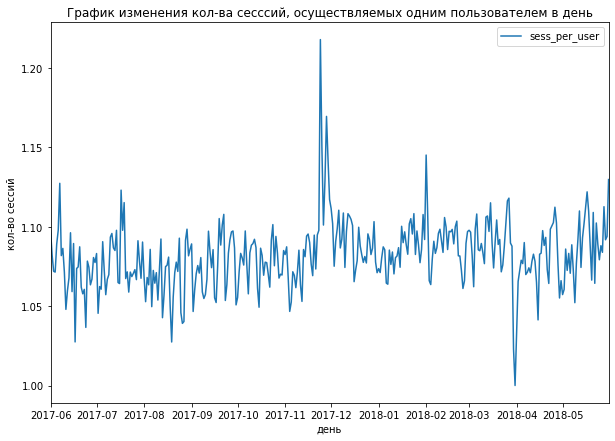

In [22]:
sessions_per_user = visits.groupby('session_date').agg({'user_id': ['count','nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sess_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
session = sessions_per_user.plot(y ='sess_per_user', figsize=(10, 7))
session.set_title("График изменения кол-ва сесссий, осуществляемых одним пользователем в день")
session.set_ylabel('кол-во сессий')
session.set_xlabel('день')

In [23]:
print('Среднее кол-во сессий, совершаемых пользователем в день, -', sessions_per_user['sess_per_user'].mean().round(2))


Среднее кол-во сессий, совершаемых пользователем в день, - 1.08


Также проанализируем, сколько времени пользователи проводят на сайте, и узнаем продолжительность типичной пользовательской сессии за весь период.

0    60
dtype: int64

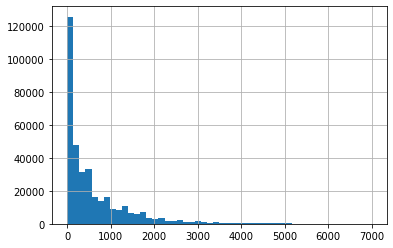

In [24]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
visits['session_duration_sec'].hist(bins=50, range=(0, 7000))
#visits['session_duration_sec'].mean() 
visits['session_duration_sec'].mode()

In [25]:
print('Продолжительность типичной пользовательской сессии за весь период:', int(visits['session_duration_sec'].mode()), 'сек.')

Продолжительность типичной пользовательской сессии за весь период: 60 сек.


### Вывод

Как можно увидеть, среднее кол-во сессий, совершаемых пользователем в день, - 1.08, что означает, что в среднем пользователи заходят на сервис 1 раз в день, что достаточно естетственно. Пользователю хватает 1 минуты, чтобы найти необходимую информацию, значит, сервис удобен и позволяет быстро находить необходимую информацию.

Рассчитаем Retention Rate, применяя когортный анализ, и изучим изменение метрики во времени на графике.

In [26]:
first_activity_date = visits.groupby('user_id')['start_ts'].min()
first_activity_date.name = 'first_activity_date'
visits = visits.merge(first_activity_date,on='user_id') 
visits.head(5)

,device,end_ts,source_id,start_ts,user_id,session_year,session_month,session_week,session_date,session_duration_sec,first_activity_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-01-01,2017-12-01,2017-12-14,2017-12-20,1080,2017-12-20 17:20:00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-01-01,2018-02-01,2018-02-15,2018-02-19,1680,2018-02-19 16:53:00
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-01-01,2017-07-01,2017-06-29,2017-07-01,0,2017-07-01 01:54:00
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-01-01,2018-05-01,2018-05-17,2018-05-20,1440,2018-03-09 20:05:00
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-01-01,2018-03-01,2018-03-08,2018-03-09,1680,2018-03-09 20:05:00


In [27]:
visits['activity_month'] = pd.to_datetime(visits['start_ts']).astype('datetime64[M]')
visits['first_activity_month'] = pd.to_datetime(visits['first_activity_date']).astype('datetime64[M]')

In [28]:
visits['cohort_lifetime'] = visits['activity_month'] - visits['first_activity_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype(int)
visits.head(5)

,device,end_ts,source_id,start_ts,user_id,session_year,session_month,session_week,session_date,session_duration_sec,first_activity_date,activity_month,first_activity_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-01-01,2017-12-01,2017-12-14,2017-12-20,1080,2017-12-20 17:20:00,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-01-01,2018-02-01,2018-02-15,2018-02-19,1680,2018-02-19 16:53:00,2018-02-01,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-01-01,2017-07-01,2017-06-29,2017-07-01,0,2017-07-01 01:54:00,2017-07-01,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-01-01,2018-05-01,2018-05-17,2018-05-20,1440,2018-03-09 20:05:00,2018-05-01,2018-03-01,2
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-01-01,2018-03-01,2018-03-08,2018-03-09,1680,2018-03-09 20:05:00,2018-03-01,2018-03-01,0


In [29]:
cohorts = visits.groupby(['first_activity_month','cohort_lifetime']).agg({'user_id':'nunique'}).reset_index()

In [30]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][
    ['first_activity_month', 'user_id']
]
initial_users_count = initial_users_count.rename(columns={'user_id':'cohort_users'})
cohorts = cohorts.merge(initial_users_count,on='first_activity_month')

In [31]:
cohorts['retention'] = cohorts['user_id']/cohorts['cohort_users']

In [35]:
retention_pivot = cohorts.pivot_table(
    index='first_activity_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum',
) 

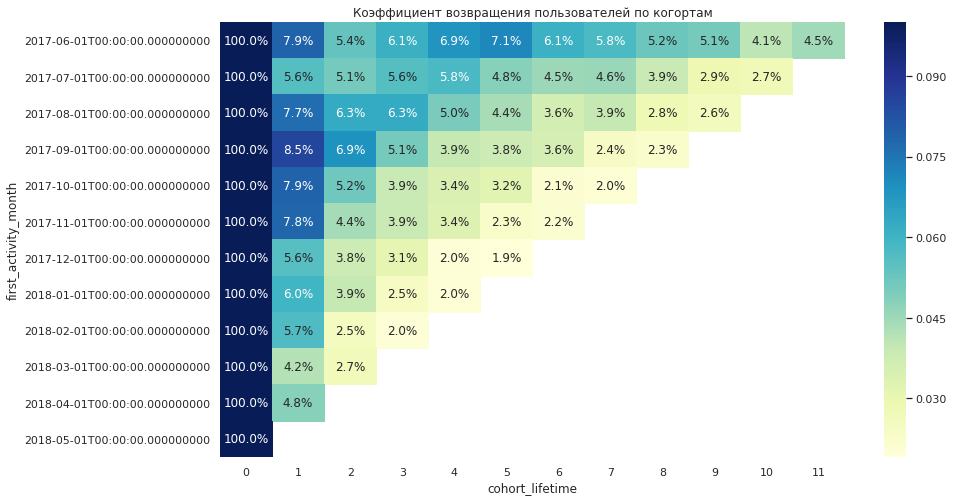

In [37]:
sns.set(style='white')
plt.figure(figsize=(14, 8))
plt.title('Коэффициент возвращения пользователей по когортам')
sns.heatmap(retention_pivot,cmap="YlGnBu", annot=True, fmt='.1%',  vmax=0.1, linecolor='gray')

Найдем средний Retention Rate на второй месяц «жизни» когорт.

In [38]:
print('В среднем {0:.0%} пользователей возвращается на второй месяц жизни когорт'.format(retention_pivot[2].mean()))

В среднем 5% пользователей возвращается на второй месяц жизни когорт


### Вывод

Коэффициент удержания пользователей на второй месяц жизни когорт кажется достаточно низким - лишь 5% пользователей возвращается. Тем не менее, если учесть специфику сервиса, то такой коэффициент будет казаться оправданным, ведт покупка билетов на концерт или в кино - это чаще всего разовое мероприятие. Тем не менее, коэффициент удержания снижается медленнее у первых 3 когорт(7,9 - 5,4% у первой когорты против 4,2-2,7% у десятой когорты) - возможно, это в некотором смысле ценители "культурной жизни".

## Метрики электронной коммерции

Изучим метрики электронной коммерции: исследуем, сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки

In [39]:
first_session = visits.groupby('user_id')['start_ts'].min() 
first_session.name = 'first_session'
first_session.head()

user_id
11863502262781    2018-03-01 17:27:00
49537067089222    2018-02-06 15:55:00
297729379853735   2017-06-07 18:47:00
313578113262317   2017-09-18 22:49:00
325320750514679   2017-09-30 14:29:00
Name: first_session, dtype: datetime64[ns]

In [40]:
orders_time = orders.merge(first_session, on='user_id')
orders_time

,buy_ts,revenue,user_id,first_session
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00
...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 09:11:00
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:05:00
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:52:00
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2017-10-23 12:32:00


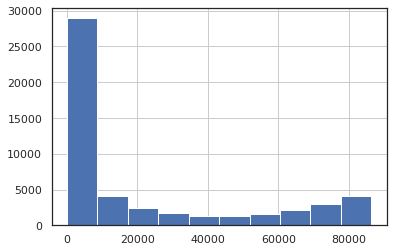

In [41]:
orders_time['buying_time'] = (orders_time['buy_ts'] - orders_time['first_session']).dt.seconds
orders_time['buying_time'].hist()

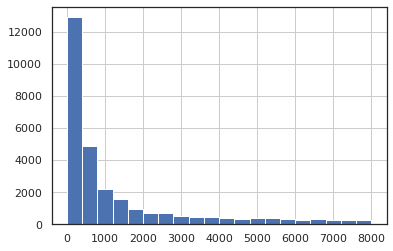

In [42]:
orders_time['buying_time'].hist(range=(0,8000), bins = 20)

In [43]:
orders_time['buying_time'].mode()

0    60
dtype: int64

### Вывод

Как видно из графика, с момента первого посещения сайта до покупки в среднем пользователям хватает 1 минуты - это лишний раз доказывает удобство сервиса и характеризует пользователей как тех, кто точно знает, что хочет найти, и не тратит время на поиск.

Следующим шагом рассчитаем среднее количество покупок на одного покупателя за 6 месяцев. 

In [44]:
orders_time['first_order_month'] = orders_time['first_session'].astype(
    'datetime64[M]'
)
orders_time['order_month'] = orders_time['buy_ts'].astype('datetime64[M]')

In [45]:
orders_time['delta_time'] = orders_time['order_month'] - orders_time['first_order_month'] 

In [46]:
orders_time['delta_time'] = orders_time['delta_time']/ np.timedelta64(1, 'M')
orders_time['delta_time']= (orders_time['delta_time'].round().astype('int'))
orders_time

,buy_ts,revenue,user_id,first_session,buying_time,first_order_month,order_month,delta_time
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,60,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,660,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,120,2017-06-01,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,900,2017-06-01,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,1620,2017-06-01,2017-06-01,0
...,...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 09:11:00,52740,2018-05-01,2018-05-01,0
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:05:00,2700,2018-05-01,2018-05-01,0
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:52:00,120,2018-05-01,2018-05-01,0
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2017-10-23 12:32:00,41040,2017-10-01,2018-05-01,7


In [47]:
six_months = orders_time[orders_time['delta_time'] <= 6]
six_months.groupby('user_id')['revenue'].count().mean()

1.3322361080116045

In [48]:
six_months.groupby(['user_id']).agg({'buy_ts':'count'})

,buy_ts
user_id,
313578113262317,1
1575281904278712,2
2429014661409475,1
2464366381792757,1
2551852515556206,2
...,...
18442290965339407211,1
18445147675727495770,1
18445407535914413204,3


In [49]:
mean_purchases = six_months.groupby(['user_id']).agg({'buy_ts':'count'}).mean()[0].round(2)
print('Cреднее количество покупок на одного покупателя в течение 6 месяцев составляет', mean_purchases)

Cреднее количество покупок на одного покупателя в течение 6 месяцев составляет 1.33


За пол года каждый покупатель делает примерно 1.3 заказа, что является достаточно хорошим результатом.

Рассчитаем средний чек, применяя группировку по времени совершения покупки. Построем график, отражающий изменения метрики во времени;

In [50]:
mean_revenue = orders_time.groupby('order_month').agg({'revenue': 'mean'})
mean_revenue.mean().round(1)

revenue    4.8
dtype: float64

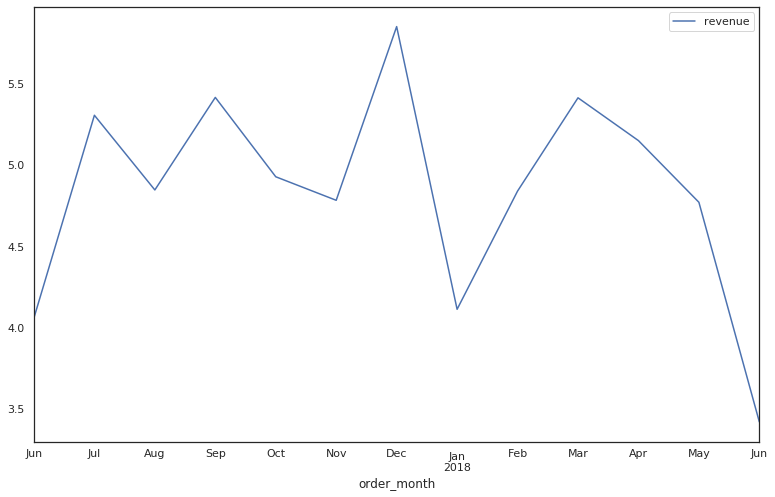

In [51]:
mean_revenue.plot(y ='revenue',figsize = (13,8))

### Вывод

Средний чек составляет около 5 у.е. На графике по месяцам заметно снижение среднего чека до 4 у.е. в январе, судя по всему, в этот период люди предпочитают оставаться дома.

Выясним, как меняется LTV на покупателя по когортам. Рассчитаем средний LTV по когортам за 6 месяцев; в расчёт включим когорты, «прожившие» не менее 6 месяцев. Маржинальность сервиса — 100%. Отразим изменения метрики во времени на графике.

In [52]:
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')

In [53]:
first_orders = orders.groupby('user_id').agg({'buy_ts': 'min'}).reset_index()
first_orders.columns = ['user_id', 'first_order_ts']
first_orders['first_order_month'] = first_orders['first_order_ts'].astype('datetime64[M]')
first_orders.head(5)

,user_id,first_order_ts,first_order_month
0,313578113262317,2018-01-03 21:51:00,2018-01-01
1,1575281904278712,2017-06-03 10:13:00,2017-06-01
2,2429014661409475,2017-10-11 18:33:00,2017-10-01
3,2464366381792757,2018-01-28 15:54:00,2018-01-01
4,2551852515556206,2017-11-24 10:14:00,2017-11-01


In [54]:
cohort_sizes = (
    first_orders.groupby('first_order_month')
    .agg({'user_id': 'nunique'})
    .reset_index()
)
cohort_sizes

,first_order_month,user_id
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


In [55]:
cohorts = pd.merge(orders, first_orders, how='inner', on='user_id')\
          .groupby(['first_order_month', 'order_month'])\
          .agg({'revenue': 'sum'}).reset_index()
cohorts

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58
...,...,...,...
74,2018-03-01,2018-05-01,1114.87
75,2018-04-01,2018-04-01,10600.69
76,2018-04-01,2018-05-01,1209.92
77,2018-05-01,2018-05-01,13925.76


In [56]:
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
margin_rate = 1
report['gp'] = report['revenue'] * margin_rate
report['age'] = (
    report['order_month'] - report['first_order_month']
) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int') 

In [57]:
report['ltv'] = report['gp'] / report['user_id']
print(report)

   first_order_month  user_id order_month   revenue        gp  age       ltv
0         2017-06-01     2023  2017-06-01   9557.49   9557.49    0  4.724414
1         2017-06-01     2023  2017-07-01    981.82    981.82    1  0.485329
2         2017-06-01     2023  2017-08-01    885.34    885.34    2  0.437637
3         2017-06-01     2023  2017-09-01   1931.30   1931.30    3  0.954671
4         2017-06-01     2023  2017-10-01   2068.58   2068.58    4  1.022531
..               ...      ...         ...       ...       ...  ...       ...
74        2018-03-01     3533  2018-05-01   1114.87   1114.87    2  0.315559
75        2018-04-01     2276  2018-04-01  10600.69  10600.69    0  4.657597
76        2018-04-01     2276  2018-05-01   1209.92   1209.92    1  0.531599
77        2018-05-01     2988  2018-05-01  13925.76  13925.76    0  4.660562
78        2018-06-01        1  2018-06-01      3.42      3.42    0  3.420000

[79 rows x 7 columns]


In [58]:
ltv_pivot = report.pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='mean').round(2)
ltv_pivot = ltv_pivot.cumsum(axis=1)
ltv_pivot.index = ltv_pivot.index.strftime("%m/%Y")

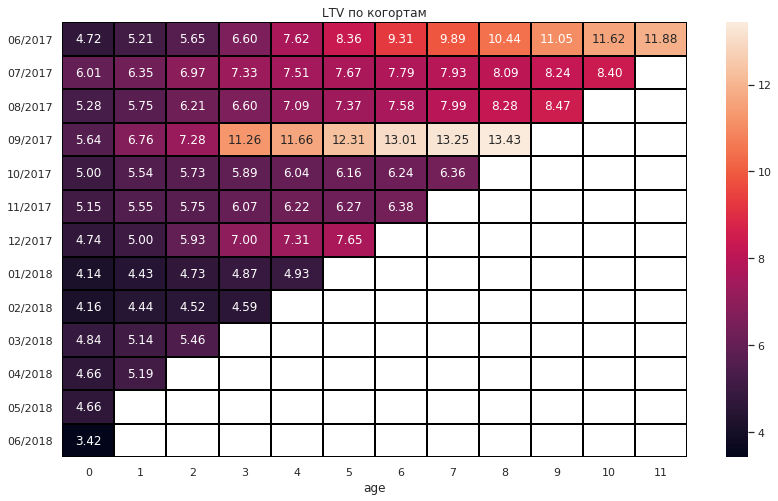

In [59]:
plt.figure(figsize=(14,8))
sns.heatmap(ltv_pivot, annot=True, fmt='.2f', linewidth=1, linecolor='black')
plt.title('LTV по когортам')
plt.show()

In [60]:
ltv_pivot[ltv_pivot.index <= '2017-12-01'][5].mean().round(2)

7.97

### Вывод

Как можно увидеть на тепловой карте, в среднем каждый пользователь когорты приносит 4 у.е., который за полгода увеличился до 8, что является достаточно хорошим показателем. Из всех когорт выделяется 1 и 4, так как у них виден достаточно большой рост суммы денег, которую один клиент приносит в среднем со всех своих покупок, при этом рост начинается с 3 года жизни кгорты (возможно, проводилась какая-то дополнительная реклама, акция).

## Маркетинговые метрики

Перейдем к расчету маркетинговых метрик. В первую очередь посчитаем общую сумму расходов на маркетинг и выясним, как траты распределены по источникам.

In [61]:
costs['costs'].sum()

329131.62

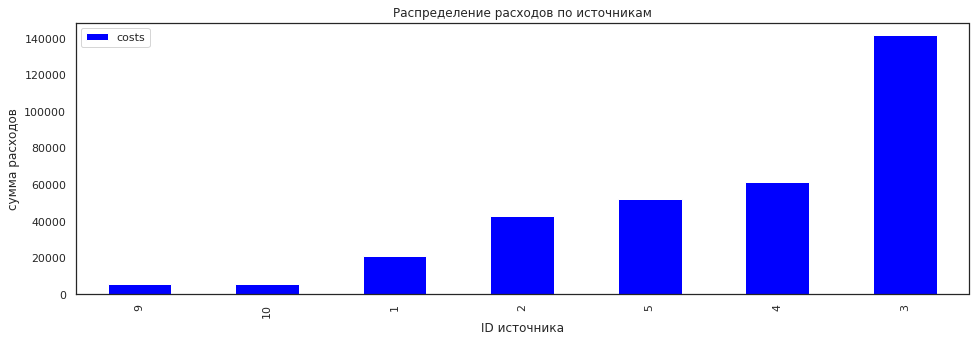

In [62]:
costs_sources = costs.groupby('source_id').agg({'costs':'sum'})
costs_sources.sort_values(by='costs').plot(kind='bar', figsize=(16,5), color='blue')
plt.title('Распределение расходов по источникам')
plt.xlabel('ID источника')
plt.ylabel('cумма расходов')
plt.show()

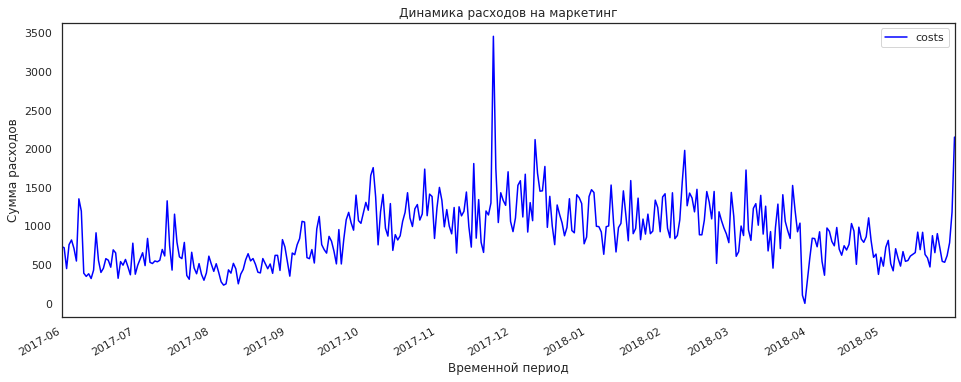

In [63]:
costs.groupby('date').agg({'costs': 'sum'}).plot(figsize=(16,6), color='blue')
plt.title('Динамика расходов на маркетинг')
plt.xlabel('Временной период')
plt.ylabel('Сумма расходов')
plt.show()

### Вывод

Как можно увидеть из графика, пик затрат был также достигнут в декабре 2017 г., что подтверждает наше предположение о проведении дополнительных рекламных мероприятий по привлечению новых пользователей в этот период. Источник, в который было вложено больше всего денег - третий (вложено 140 т.у.е. из 329 т. у.е. всего).

Рассчитаем средний CAC на одного покупателя для всего проекта и для каждого источника трафика. Отразим изменения метрик на графиках

In [64]:
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
costs['month'] = costs['date'].astype('datetime64[M]')

In [65]:
costs_month = costs.groupby('month').agg({'costs':'sum'}).reset_index()
costs_month.columns = ['first_order_month', 'costs']
costs_month.head(5)

,first_order_month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88


In [66]:
first_orders = orders.groupby('user_id').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['user_id', 'first_order_month']

In [67]:
cohort_sizes = (
    first_orders.groupby('first_order_month')
    .agg({'user_id': 'nunique'})
    .reset_index()
)
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes.head(5)

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


In [68]:
orders_new = pd.merge(costs_month,cohort_sizes, on='first_order_month')
orders_new['cac'] =  orders_new['costs'] / orders_new['n_buyers']
orders_new

,first_order_month,costs,n_buyers,cac
0,2017-06-01,18015.00,2023,8.905091
1,2017-07-01,18240.59,1923,9.485486
2,2017-08-01,14790.54,1370,10.796015
3,2017-09-01,24368.91,2581,9.441654
4,2017-10-01,36322.88,4340,8.369327
5,2017-11-01,37907.88,4081,9.288870
6,2017-12-01,38315.35,4383,8.741809
7,2018-01-01,33518.52,3373,9.937302
8,2018-02-01,32723.03,3651,8.962758
9,2018-03-01,30415.27,3533,8.608907


In [69]:
orders_new['cac'].mean()

9.147357292482544

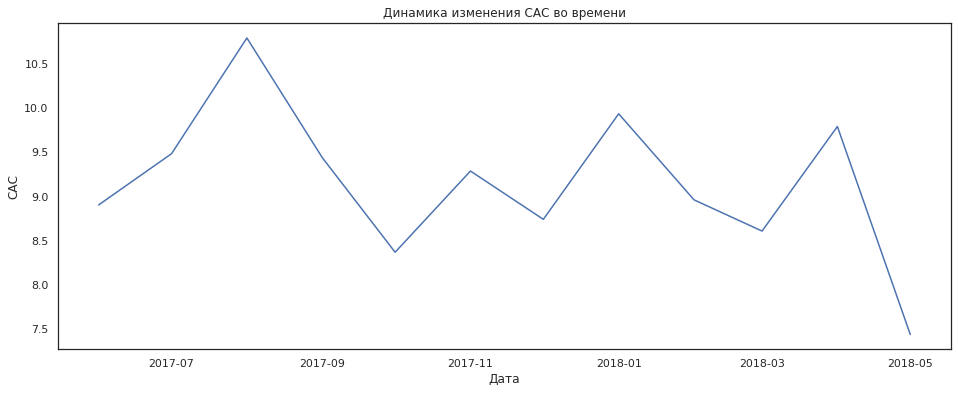

In [70]:
plt.figure(figsize=(16,6))
sns.lineplot(data=orders_new, x='first_order_month', y='cac')
plt.title('Динамика изменения CAC во времени')
plt.xlabel('Дата')
plt.ylabel('CAC')
plt.show()

In [71]:
users = visits.sort_values(by = ['user_id', 'start_ts']).groupby('user_id').agg({'source_id': 'first', 
                                                                         'session_date': 'first'})
users.head(5)

,source_id,session_date
user_id,,
11863502262781,3,2018-03-01
49537067089222,2,2018-02-06
297729379853735,3,2017-06-07
313578113262317,2,2017-09-18
325320750514679,5,2017-09-30


In [72]:
orders_sources = pd.merge(users, first_orders, on='user_id')
orders_sources

,user_id,source_id,session_date,first_order_month
0,313578113262317,2,2017-09-18,2018-01-01
1,1575281904278712,10,2017-06-03,2017-06-01
2,2429014661409475,3,2017-10-11,2017-10-01
3,2464366381792757,5,2018-01-27,2018-01-01
4,2551852515556206,5,2017-11-24,2017-11-01
...,...,...,...,...
36518,18445147675727495770,5,2017-08-20,2017-11-01
36519,18445407535914413204,3,2017-09-22,2017-09-01
36520,18445601152732270159,2,2017-08-07,2018-03-01
36521,18446156210226471712,3,2017-11-07,2018-02-01


In [73]:
visits_by_source = (orders_sources.groupby(['source_id', 'session_date']).agg({'user_id': 'nunique'}).reset_index())
visits_by_source.columns = ['source_id','group_month','n_buyers']
visits_by_source.head()

,source_id,group_month,n_buyers
0,1,2017-06-01,24
1,1,2017-06-02,12
2,1,2017-06-03,8
3,1,2017-06-04,6
4,1,2017-06-05,20


In [74]:
df1 = orders_sources.groupby(['first_order_month', 'source_id']).agg({'user_id': 'nunique'}).reset_index()
df1.head(5)

,first_order_month,source_id,user_id
0,2017-06-01,1,190
1,2017-06-01,2,235
2,2017-06-01,3,638
3,2017-06-01,4,413
4,2017-06-01,5,384


In [75]:
costs_by_source = costs.groupby(['source_id', 'month'])['costs'].sum().reset_index()
costs_by_source.columns = ['source_id', 'group_month', 'costs']
costs_by_source.head()

,source_id,group_month,costs
0,1,2017-06-01,1125.61
1,1,2017-07-01,1072.88
2,1,2017-08-01,951.81
3,1,2017-09-01,1502.01
4,1,2017-10-01,2315.75


In [76]:
df = df1.merge(costs_by_source, left_on=['first_order_month', 'source_id'], right_on=['group_month', 'source_id'])
df = df[['group_month', 'source_id', 'user_id', 'costs']]
df.head()

,group_month,source_id,user_id,costs
0,2017-06-01,1,190,1125.61
1,2017-06-01,2,235,2427.38
2,2017-06-01,3,638,7731.65
3,2017-06-01,4,413,3514.80
4,2017-06-01,5,384,2616.12


,cac
source_id,
10,4.867125
9,5.413892
4,6.439374
1,7.212107
5,7.451938
2,12.504068
3,13.802743


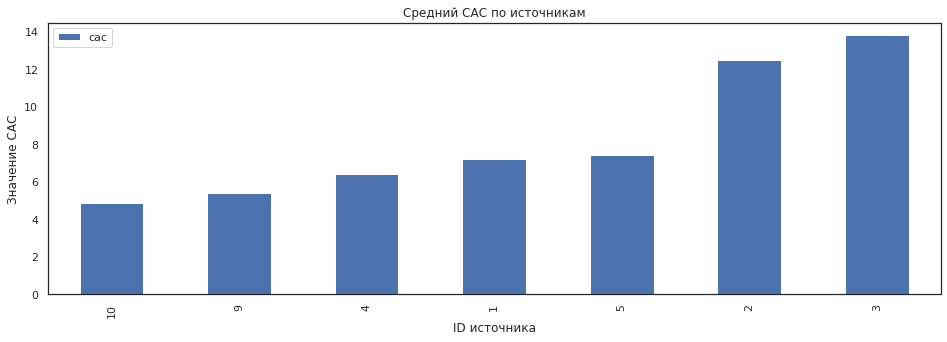

In [77]:
df['cac'] = df['costs'] / df['user_id']
display(df.groupby('source_id').agg({'cac': 'mean'}).sort_values(by='cac'))
df.groupby('source_id').agg({'cac': 'mean'}).sort_values(by='cac').plot(kind='bar', figsize=(16,5))
plt.title('Средний CAC по источникам')
plt.xlabel('ID источника')
plt.ylabel('Значение САС')
plt.show()

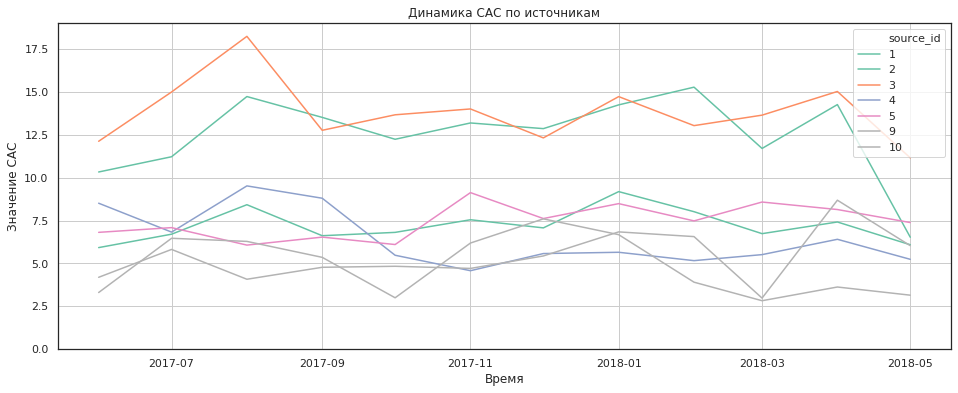

In [78]:
plt.figure(figsize=(16,6))
sns.lineplot(data=df, x='group_month', y='cac', hue='source_id', palette='Set2', legend='full')
plt.title('Динамика CAC по источникам')
plt.xlabel('Время')
plt.ylabel('Значение САС')
plt.ylim(0)
plt.grid()
plt.show()

### Вывод

Самая высокая стоимость привлечения клиента из третьего и второго источника. 

Рассчитаем ROMI по когортам в разрезе источников. Сравним окупаемость за одинаковые периоды жизни когорт.

In [79]:
first_source = visits.groupby('user_id')['source_id'].first()
first_source.name = 'first_source'
first_source

user_id
11863502262781          3
49537067089222          2
297729379853735         3
313578113262317         2
325320750514679         5
                       ..
18446403737806311543    5
18446424184725333426    4
18446556406699109058    3
18446621818809592527    4
18446676030785672386    3
Name: first_source, Length: 228169, dtype: int64

In [80]:
first_orders = orders.groupby('user_id').agg({'buy_ts': 'min'}).reset_index()
first_orders.columns = ['user_id', 'first_order_ts']
first_orders['first_order_month'] = first_orders['first_order_ts'].astype('datetime64[M]')
first_orders.head(5)

,user_id,first_order_ts,first_order_month
0,313578113262317,2018-01-03 21:51:00,2018-01-01
1,1575281904278712,2017-06-03 10:13:00,2017-06-01
2,2429014661409475,2017-10-11 18:33:00,2017-10-01
3,2464366381792757,2018-01-28 15:54:00,2018-01-01
4,2551852515556206,2017-11-24 10:14:00,2017-11-01


In [81]:
orders = orders.merge(first_orders, on='user_id')
orders.head()

,buy_ts,revenue,user_id,order_month,first_order_ts,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:10:00,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:25:00,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01 00:27:00,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01 00:29:00,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01 07:58:00,2017-06-01


In [82]:
orders = orders.merge(first_source, on='user_id')
orders.head()

,buy_ts,revenue,user_id,order_month,first_order_ts,first_order_month,first_source
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:10:00,2017-06-01,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:25:00,2017-06-01,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01 00:27:00,2017-06-01,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01 00:29:00,2017-06-01,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01 07:58:00,2017-06-01,3


In [83]:
monthly_costs = costs.groupby(['month', 'source_id'])['costs'].sum().reset_index()
monthly_costs.head()

,month,source_id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12


In [84]:
orders['lifetime'] = (orders['order_month']- orders['first_order_month'])/ np.timedelta64(1,'M')
orders['lifetime'] = orders['lifetime'].round().astype('int')
orders.head(5)

,buy_ts,revenue,user_id,order_month,first_order_ts,first_order_month,first_source,lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:10:00,2017-06-01,1,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:25:00,2017-06-01,2,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01 00:27:00,2017-06-01,2,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01 00:29:00,2017-06-01,2,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01 07:58:00,2017-06-01,3,0


In [85]:
cohorts = (orders
           .groupby(['first_order_month', 'lifetime', 'first_source'])
           .agg({'revenue': 'sum', 'user_id': 'nunique'})
           .reset_index()
          )
cohorts.head()

,first_order_month,lifetime,first_source,revenue,user_id
0,2017-06-01,0,1,1168.45,203
1,2017-06-01,0,2,1551.76,271
2,2017-06-01,0,3,2466.71,574
3,2017-06-01,0,4,2039.64,417
4,2017-06-01,0,5,1787.68,368


In [86]:
cohorts = cohorts.merge(monthly_costs, left_on=['first_order_month', 'first_source'], right_on=['month', 'source_id'])

In [87]:
cohorts['ltv'] = cohorts['revenue'] / cohorts['user_id']
cohorts['cac'] = cohorts['costs'] / cohorts['user_id']
cohorts['romi'] = cohorts['ltv'] / cohorts['cac']
cohorts.head()

,first_order_month,lifetime,first_source,revenue,user_id,month,source_id,costs,ltv,cac,romi
0,2017-06-01,0,1,1168.45,203,2017-06-01,1,1125.61,5.755911,5.544877,1.038059
1,2017-06-01,1,1,362.94,11,2017-06-01,1,1125.61,32.994545,102.328182,0.322439
2,2017-06-01,2,1,153.72,10,2017-06-01,1,1125.61,15.372000,112.561000,0.136566
3,2017-06-01,3,1,695.88,13,2017-06-01,1,1125.61,53.529231,86.585385,0.618225
4,2017-06-01,4,1,760.74,14,2017-06-01,1,1125.61,54.338571,80.400714,0.675847


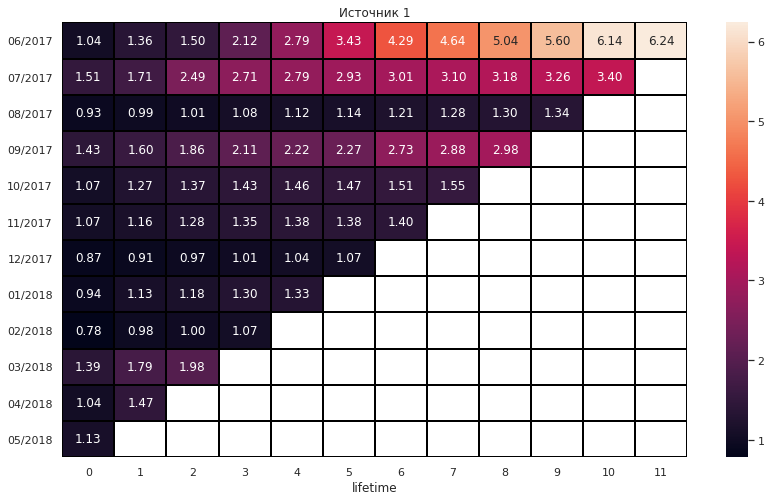

In [88]:
table = cohorts[cohorts['first_source'] == 1]
table_pivot = table.pivot_table(index='first_order_month', columns='lifetime', values='romi', aggfunc ='mean').cumsum(axis=1).round(2)
table_pivot.index = table_pivot.index.strftime("%m/%Y")
plt.figure(figsize=(14,8))
sns.heatmap(table_pivot, annot=True, fmt='.2f', linewidth=1, linecolor='black')
plt.title('Источник 1')
plt.show()

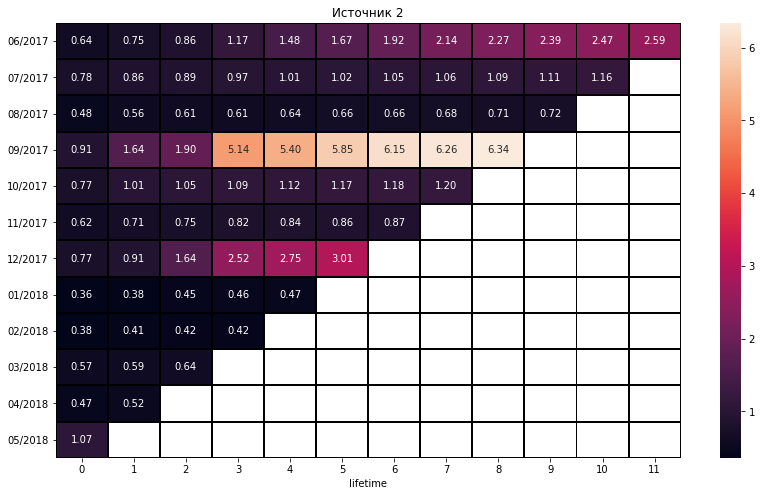

In [50]:
table = cohorts[cohorts['first_source'] == 2]
table_pivot = table.pivot_table(index='first_order_month', columns='lifetime', values='romi', aggfunc = 'mean').cumsum(axis=1).round(2)
table_pivot.index = table_pivot.index.strftime("%m/%Y")
plt.figure(figsize=(14,8))
sns.heatmap(table_pivot, annot=True, fmt='.2f', linewidth=1, linecolor='black')
plt.title('Источник 2')
plt.show()

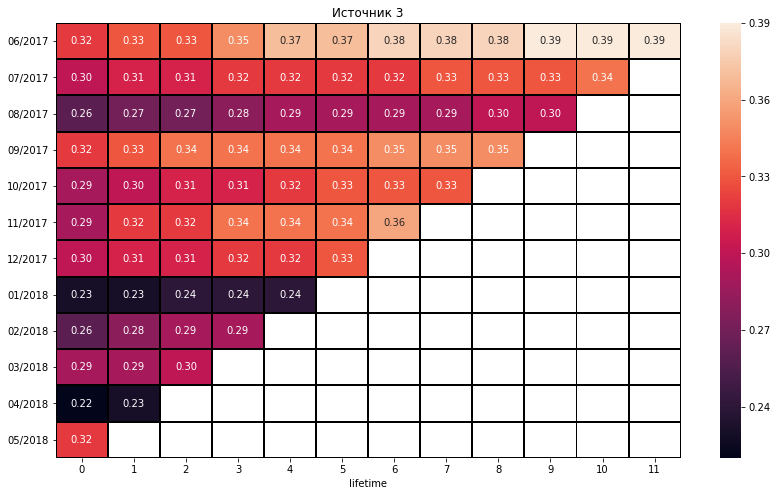

In [52]:
table = cohorts[cohorts['first_source'] == 3]
table_pivot = table.pivot_table(index='first_order_month', columns='lifetime', values='romi', aggfunc = 'mean').cumsum(axis=1).round(2)
table_pivot.index = table_pivot.index.strftime("%m/%Y")
plt.figure(figsize=(14,8))
sns.heatmap(table_pivot, annot=True, fmt='.2f', linewidth=1, linecolor='black')
plt.title('Источник 3')
plt.show()

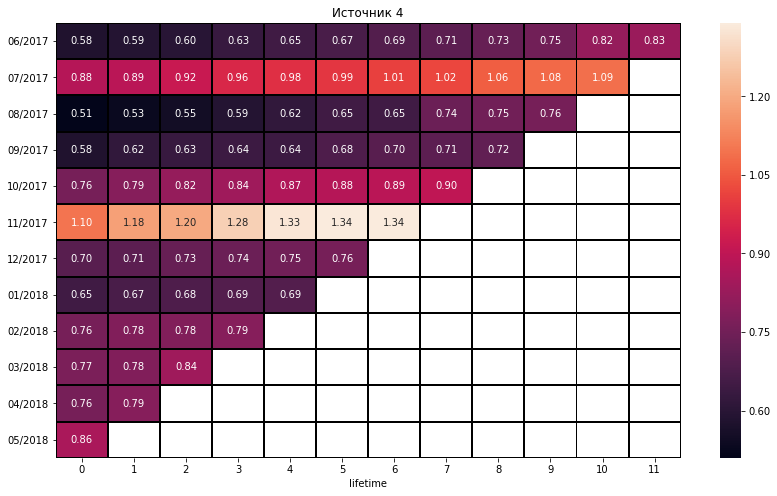

In [55]:
table = cohorts[cohorts['first_source'] == 4]
table_pivot = table.pivot_table(index='first_order_month', columns='lifetime', values='romi',aggfunc = 'mean').cumsum(axis=1).round(2)
table_pivot.index = table_pivot.index.strftime("%m/%Y")
plt.figure(figsize=(14,8))
sns.heatmap(table_pivot, annot=True, fmt='.2f', linewidth=1, linecolor='black')
plt.title('Источник 4')
plt.show()

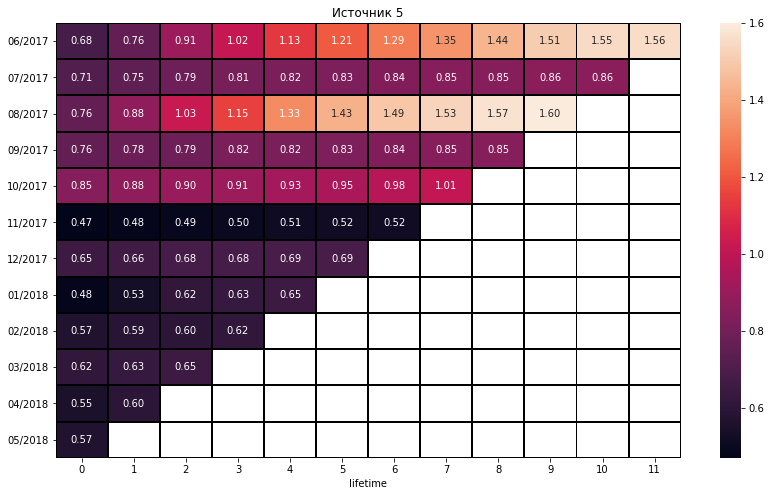

In [60]:
table = cohorts[cohorts['first_source'] == 5]
table_pivot = table.pivot_table(index='first_order_month', columns='lifetime', values='romi',aggfunc = 'mean').cumsum(axis=1).round(2)
table_pivot.index = table_pivot.index.strftime("%m/%Y")
plt.figure(figsize=(14,8))
sns.heatmap(table_pivot, annot=True, fmt='.2f', linewidth=1, linecolor='black')
plt.title('Источник 5')
plt.show()

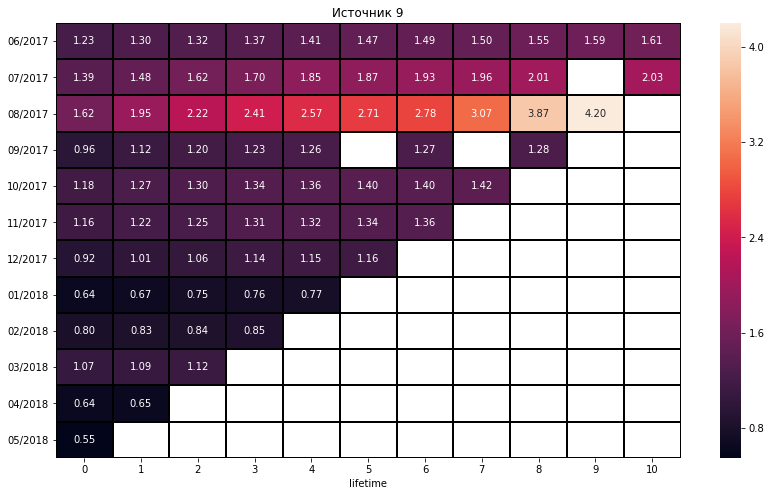

In [56]:
table = cohorts[cohorts['first_source'] == 9]
table_pivot = table.pivot_table(index='first_order_month', columns='lifetime', values='romi', aggfunc = 'mean').cumsum(axis=1).round(2)
table_pivot.index = table_pivot.index.strftime("%m/%Y")
plt.figure(figsize=(14,8))
sns.heatmap(table_pivot, annot=True, fmt='.2f', linewidth=1, linecolor='black')
plt.title('Источник 9')
plt.show()

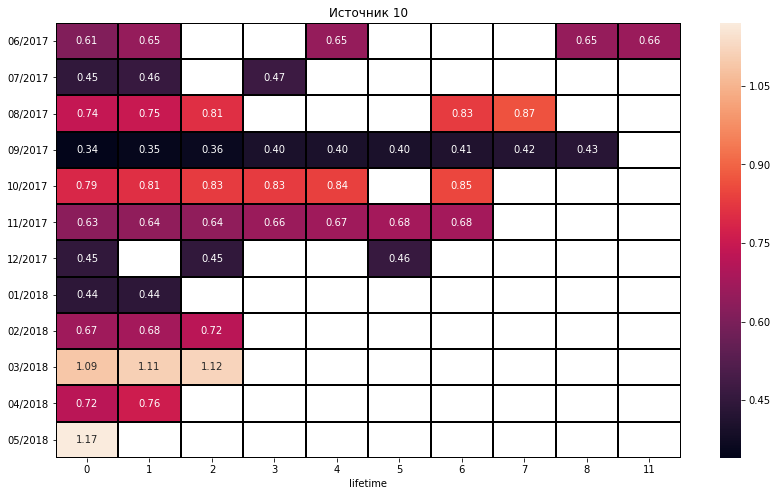

In [57]:
table = cohorts[cohorts['first_source'] == 10]
table_pivot = table.pivot_table(index='first_order_month', columns='lifetime', values='romi', aggfunc = 'mean').cumsum(axis=1).round(2)
table_pivot.index = table_pivot.index.strftime("%m/%Y")
plt.figure(figsize=(14,8))
sns.heatmap(table_pivot, annot=True, fmt='.2f', linewidth=1, linecolor='black')
plt.title('Источник 10')
plt.show()

In [59]:
sources = cohorts['first_source'].unique()
for i in sources:
    table = cohorts[cohorts['first_source'] == i]
    table_pivot = table.pivot_table(index='first_order_month', columns='lifetime', values='romi', aggfunc = 'mean').cumsum(axis=1).round(1)
    print('Средний ROMI за полгода по источнику ' + str(i),':', table_pivot[5].mean().round(2))

Средний ROMI за полгода по источнику 1 : 1.96
Средний ROMI за полгода по источнику 2 : 2.06
Средний ROMI за полгода по источнику 3 : 0.31
Средний ROMI за полгода по источнику 4 : 0.86
Средний ROMI за полгода по источнику 5 : 0.91
Средний ROMI за полгода по источнику 9 : 1.67
Средний ROMI за полгода по источнику 10 : 0.53


ROI по каналам показывает, что лучше всех окупился второй канал, показатель ROMI которого почти 206%, также на окупаемость вышел канал №1 - 196%.

## Выводы

Таким образом, можно сказать, что, изучив информацию о потоке посетителей,можно отметить, что в день сервис посещают 907 человек, в неделю - 5716, в месяц - 23228, что является достаточно хорошим показателем, кроме того, количество уникальных посетителей  растет. В среднем посльзователю хватает одной сессии и 1 минуты для получения необходимой информации и покупки билета, что говорит об удобстве сервиса. Коэффициент удержания в среднем составляет 5%, что достаточно естественно для нашего сервиса, мало кто пользуется им каждый день. Средний чек составляет 5 у.е., а в  среднем каждый пользователь когорты приносит 4 у.е., который за полгода увеличился до 8, что является достаточно хорошим показателем. Из всех когорт выделяется 1 и 4, так как у них виден достаточно большой рост суммы денег, которую один клиент приносит в среднем со всех своих покупок. Наибольшее количество маркетинговых затрат(с большим отрывом от остальных) приходится на 3 источник.При этом самая высокая стоимость привлечения клиента из третьего и второго источника, в то время как возврат на маркетинговые инвестиции у третьего источника - один из самых низких. В свою очередь второй источник имеет CAC выше остальных, но самый высокий ROMI, интерес представляет и первый источник с достаточно высоким CAC и ROMI. Также видится необходимым вкладывать больше денег в 9 источник: сейчас, несмотря на небольшие вложения, его окупаемость достаточно высокая. 
Анализируя когорты, следует сказать, что наиболее хороший коэффициент удержания демонстрирует первая когорта, у нее высокий и растущий LTV и CAC.